In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42383")
client

<Client: 'tcp://127.0.0.1:42383' processes=8 threads=40, memory=157.39 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import xrft
import xwavelet
from scipy.interpolate import interp2d, bisplrep, bisplev, griddata
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1421280,1576800+dnf,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,:]

array([1421280, 1423440, 1425600, 1427760, 1429920, 1432080, 1434240,
       1436400, 1438560, 1440720, 1442880, 1445040, 1447200, 1449360,
       1451520, 1453680, 1455840, 1458000, 1460160, 1462320, 1464480,
       1466640, 1468800, 1470960, 1473120, 1475280, 1477440, 1479600,
       1481760, 1483920, 1486080, 1488240, 1490400, 1492560, 1494720,
       1496880, 1499040, 1501200, 1503360, 1505520, 1507680, 1509840,
       1512000, 1514160, 1516320, 1518480, 1520640, 1522800, 1524960,
       1527120, 1529280, 1531440, 1533600, 1535760, 1537920, 1540080,
       1542240, 1544400, 1546560, 1548720, 1550880, 1553040, 1555200,
       1557360, 1559520, 1561680, 1563840, 1566000, 1568160, 1570320,
       1572480, 1574640, 1576800])

In [8]:
nmembs = np.concatenate((np.arange(24),np.arange(36,60)))
xchunk = 100
ychunk = 100

yy = yystart

for year in years[yystart:]:
    if year == years[yystart]:
        mtimes = ntimes[yy,:dd+1]
    else:
        mtimes = ntimes[yy]
    for itime in mtimes:

        for nmemb in nmembs:
            if nmemb == 0:
                ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                             % (nmemb,year)), 
                                     grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                     prefix=['diag_ocnTave'], delta_t=2e2,
                                     iters=itime, 
                                    ).isel(time=0
                                          ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
            else:
                ds = xr.concat([ds, 
                                open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                                        % (nmemb,year)), 
                                                grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                                                prefix=['diag_ocnTave'], delta_t=2e2,
                                                iters=itime, 
                                               ).isel(time=0
                                                     ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1})
                               ], dim='nmemb')

        # ds = ds.chunk({'nmemb':6})
        ds.coords['nmemb'] = ('nmemb',nmembs)

ds

<xarray.Dataset>
Dimensions:  (nmemb: 48, Z: 46, YC: 900, XC: 1000, XG: 1000, YG: 900, Zp1: 47, Zu: 46, Zl: 46)
Coordinates: (12/34)
    iter     int64 1421280
    time     timedelta64[ns] 3290 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
    ...       ...
    maskS    (Z, YG, XC) bool dask.array<chunksize=(1, 900, 1000), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
  * nmemb    (nmemb) int64 0 1 2 3 4 5 6 7 8 9 ... 50 51 52 53 54 55 56 57 58 59
Data variables:
    PHIHYD   (nmemb, Z, YC, XC) float32 dask.array<chunksize=(25, 1, 900, 1000), meta=np.ndarray>
    THETA    (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 900, 1000), meta=np.ndarray>
    SALT     (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 1, 900, 1000), meta=np.ndarray>
    UVEL     (nmemb, Z, YC, XG) float32 dask.array<chunksize=(1, 1, 900, 1000), meta=np.ndarray>
    VVEL     (nmemb, Z, YG, XC) float32 dask.array<chunksize=(1, 1, 900, 1000), meta=np.ndarray>
    WVEL     (nmemb, Zl, YC, XC) float32 dask.array<chunksize=(1, 1, 900, 1000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [12]:
grid = Grid(ds, periodic=['X'])
ub = grid.interp(ds.UVEL.isel(Z=[14,24]).mean('nmemb',skipna=True),'X')
vb = grid.interp(ds.VVEL.isel(Z=[14,24]).mean('nmemb',skipna=True),'Y',boundary='extend')

In [13]:
X = grid.cumsum(ds.dxC,'X')
Y = grid.cumsum(ds.dyC,'Y',boundary='extend')

/tmp/ipykernel_17842/2083433604.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(X, Y, ub.isel(Z=0), cmap='seismic', vmax=.2, vmin=-.2)


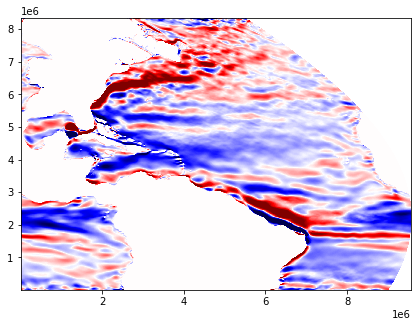

In [17]:
fig, ax = plt.subplots(figsize=(7,5))
ax.pcolor(X, Y, ub.isel(Z=0), cmap='seismic', vmax=.2, vmin=-.2)

/tmp/ipykernel_17842/378750444.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(XX, YY, ub.isel(Z=0)[400:],


(0.0, 6000000.0)

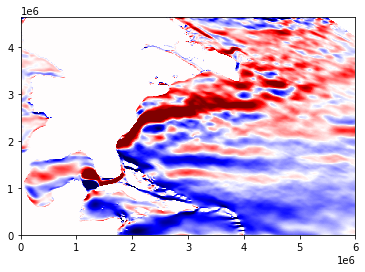

In [51]:
YY = Y[400:,] - Y[400:,].isel(YC=0)
XX = X[400:,] - X[400:,].isel(XC=0)

fig, ax = plt.subplots()
ax.pcolor(XX, YY, ub.isel(Z=0)[400:], 
          cmap='seismic', vmax=.2, vmin=-.2)
ax.set_xlim([0,6e6])

In [56]:
dx = 9e3
dy = 9e3
N = ub.isel(Z=0)[400:,].shape

ubterp = xr.DataArray(np.ones((len(np.arange(0,YY.max(),dy)),
                               len(np.arange(0,6e6,dx))
                              )), 
                      dims=ub.isel(Z=0).dims,
                      coords={'YC':np.arange(0,YY.max(),dy),
                              'XC':np.arange(0,6e6,dx)}
                     )

xT = XX.values.flatten()
yT = YY.values.flatten()
# xxx, yyy = np.mgrid[0:N[-1]*dx:dx, 0:N[-2]*dy:dy]
xxx, yyy = np.mgrid[0:6e6:dx, 0:YY.max():dy]
ubterp[:] = griddata((xT, yT), 
                     (ub*ds.rA).isel(Z=0)[400:,].values.flatten(),
                     (xxx, yyy) 
                    ).T / (dx*dy)
ubterp

<xarray.DataArray (YC: 514, XC: 667)>
array([[ 0.        ,  0.        ,  0.        , ..., -0.00434547,
        -0.00375683, -0.00313163],
       [ 0.        ,  0.        ,  0.        , ..., -0.0013684 ,
        -0.00079825, -0.00020177],
       [ 0.        ,  0.        ,  0.        , ...,  0.00163256,
         0.00215656,  0.00270252],
       ...,
       [-0.0671761 , -0.06668328, -0.06141054, ...,         nan,
                nan,         nan],
       [-0.06909565, -0.07222285, -0.07134863, ...,         nan,
                nan,         nan],
       [-0.03810308, -0.0381326 , -0.03700906, ...,         nan,
                nan,         nan]])
Coordinates:
  * YC       (YC) float64 0.0 9e+03 1.8e+04 ... 4.599e+06 4.608e+06 4.617e+06
  * XC       (XC) float64 0.0 9e+03 1.8e+04 ... 5.976e+06 5.985e+06 5.994e+06

/tmp/ipykernel_17842/1214672247.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolor(XX, YY, ub.isel(Z=0)[400:],
/tmp/ipykernel_17842/1214672247.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolormesh(xxx, yyy, ubterp.T,


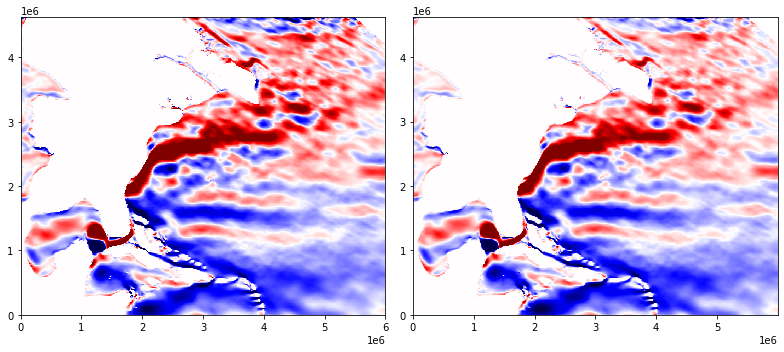

In [57]:
fig, (ax1,ax2) = plt.subplots(figsize=(11,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
ax1.pcolor(XX, YY, ub.isel(Z=0)[400:], 
           cmap='seismic', vmax=.2, vmin=-.2)
ax1.set_xlim([0,6e6])
ax2.pcolormesh(xxx, yyy, ubterp.T, 
               cmap='seismic', vmax=.2, vmin=-.2)